In [1]:
import sys
sys.path.append('../../')
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import time

from torch.utils.data import DataLoader
from Code.Networks import OuterWrapper


In [2]:
BATCH_SIZE = 128

USE_JIT = False

device = torch.device('cuda')

In [3]:
test = MNIST('../../', transform=transforms.ToTensor(), train=False)

In [4]:

test_loader = DataLoader(test, batch_size=1024, drop_last=False, num_workers=0)



In [5]:
model_name = 'big6'
n_models = 19

In [6]:
with torch.no_grad():
    for m in range(n_models):
        mem_model = OuterWrapper(torch.load('../../models/mem_'+model_name+'_'+str(m)), device, USE_JIT)
        post_model = OuterWrapper(torch.load('../../models/post_'+model_name+'_'+str(m)), device, USE_JIT)
        confusion = torch.zeros([10,10])
        i = 0
        acc = 0
        for inp, target in test_loader:
            x = inp.view(inp.shape[0], -1, 1).transpose(0,1).to(device)
            target = target.to(device)
            mem, _ = mem_model(x)
            outputs, _ = post_model(mem[-1].expand(56, x.shape[1], 256))
            choice = torch.argmax(outputs.mean(dim=0), 1)
            acc += (choice == target).float().mean()
            i += 1
            for k in range(len(target)):
                confusion[choice[k], target[k]] += 1
        print('Model '+str(m)+': '+str(acc/i))
#print(confusion)

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:563: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Model 0: tensor(0.9138, device='cuda:0')
Model 1: tensor(0.9128, device='cuda:0')
Model 2: tensor(0.9148, device='cuda:0')
Model 3: tensor(0.9124, device='cuda:0')
Model 4: tensor(0.9136, device='cuda:0')
Model 5: tensor(0.9151, device='cuda:0')
Model 6: tensor(0.9139, device='cuda:0')
Model 7: tensor(0.9146, device='cuda:0')
Model 8: tensor(0.9150, device='cuda:0')
Model 9: tensor(0.9123, device='cuda:0')
Model 10: tensor(0.9135, device='cuda:0')
Model 11: tensor(0.9155, device='cuda:0')
Model 12: tensor(0.9150, device='cuda:0')
Model 13: tensor(0.9140, device='cuda:0')
Model 14: tensor(0.9156, device='cuda:0')
Model 15: tensor(0.9158, device='cuda:0')
Model 16: tensor(0.9131, device='cuda:0')
Model 17: tensor(0.9148, device='cuda:0')
Model 18: tensor(0.9147, device='cuda:0')


In [57]:
max = confusion.max().item()
from PIL import Image
img = Image.new('L',(10,10),color=128)
for i in range(10):
    for k in range(10):
        img.putpixel((i, k), int(confusion[i,k]/max*255))

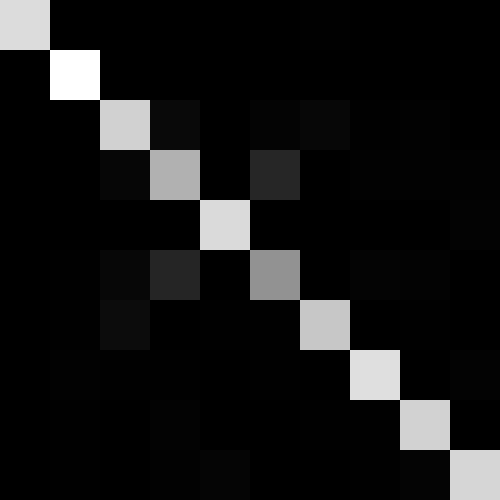

In [58]:
img.resize((500, 500))

In [24]:
testi = MNIST('../../', train=False)

In [37]:
show = []
schoice = []
starget = []
for img, target in testi:
    x = transforms.ToTensor()(img).view(-1, 1, 1).to(device)
    mem, _ = mem_model(x)
    outputs, _ = post_model(mem[-1].expand(56, 1, 256))
    choice = torch.argmax(outputs.mean(dim=0), 1).item()
    if choice != target:
        show.append(img)
        schoice.append(choice)
        starget.append(target)
        if len(show) == 10:
            break


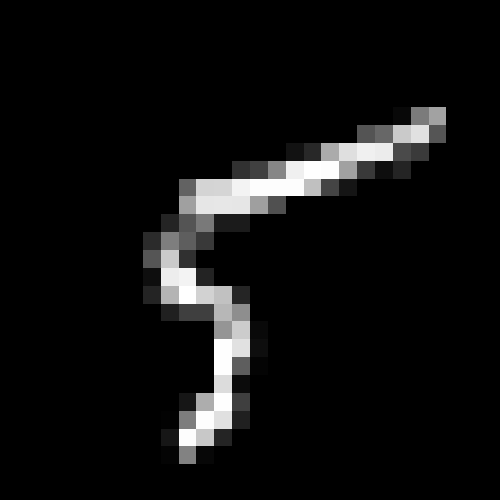

In [51]:
show[7].resize((500,500))


In [39]:
print(schoice)
print(starget)

[2, 3, 8, 5, 6, 6, 5, 7, 7, 5]
[5, 5, 3, 3, 3, 2, 3, 5, 9, 3]


5

In [51]:
mem_model.model.model.layers.shortterm_synapse.named_parameters()

<generator object Module.named_parameters at 0x7f73a476be60>

In [55]:
for name, p in n_mem.named_parameters():
    print(name, p.shape)

model.layers.pre_mem_synapse.weight torch.Size([128, 193])
model.layers.pre_mem_synapse.bias torch.Size([128])
model.layers.pre_mem.initial_mem torch.Size([128])
model.layers.shortterm_synapse.weight torch.Size([64, 128])
model.layers.shortterm_synapse.bias torch.Size([64])
model.layers.shortterm.initial_mem torch.Size([64])
model.layers.output_synapse.weight torch.Size([128, 128])
model.layers.output_synapse.bias torch.Size([128])
model.layers.output.initial_mem torch.Size([128])


In [56]:
for name, p in mem_model2.named_parameters():
    print(name, p.shape)

model.layers.pre_mem_synapse.weight torch.Size([128, 129])
model.layers.pre_mem_synapse.bias torch.Size([128])
model.layers.pre_mem.initial_mem torch.Size([128])
model.layers.output_synapse.weight torch.Size([128, 128])
model.layers.output_synapse.bias torch.Size([128])
model.layers.output.initial_mem torch.Size([128])


In [62]:
mem_model2 = torch.load('../../models/mem_nores3_76')
n_mem = make_SequenceWrapper(DynNetwork(mem_loop), USE_JIT)
with torch.no_grad():
    n_mem.model.layers.output_synapse.weight = mem_model2.model.layers.output_synapse.weight
    n_mem.model.layers.output_synapse.bias = mem_model2.model.layers.output_synapse.bias
    n_mem.model.layers.output.initial_mem = mem_model2.model.layers.output.initial_mem
    n_mem.model.layers.pre_mem_synapse.bias = mem_model2.model.layers.pre_mem_synapse.bias
    n_mem.model.layers.pre_mem.initial_mem = mem_model2.model.layers.pre_mem.initial_mem
    n_mem.model.layers.pre_mem_synapse.weight[:, :129] = mem_model2.model.layers.pre_mem_synapse.weight

In [13]:
data_loader.__iter__().__next__()[1]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4])